In [1]:
import numpy as np
import os
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random
from glob import glob
from scipy.io import wavfile
import pickle5 as pickle
import scipy.signal as sg
import librosa
import librosa.display
import datetime

In [2]:
source_folder = os.path.abspath('/mnt/cube/earneodo/bci_zf/neuropix/birds/z_w12m7_20/Ephys/processed/20201104/2500r250a_3500_dir_g0/')

In [3]:
wav_name = 'wav_mic.wav'
motif_dic_name = 'mot_dict.pkl'
cluster_meta_name = 'clu_df.pkl'
spike_data_name = 'spk_df.pkl'

In [4]:
wav_sr, seq = wavfile.read(os.path.join(source_folder, wav_name))

In [5]:
wav_sr

25000

# motif_dict

In [6]:
mot_dict = pickle.load(open(os.path.join(source_folder, motif_dic_name), 'rb'))

‘template’: np.array,

‘s_f’: int, sample_rate of the stream used to find the template

‘start_ms’: list, start in ms in the time scale of the wav_mic.wav file

‘start_sample_naive’: np.array, (for debugging: start sample expected from resamping start_ms to the nidq sample rate).

‘start_sample_nidq’: np.array, start sample in the binary (‘nidq’) imec file

‘start_t_0’:  np.array, start in sec, relative to the binary (‘nidq’) imec file

‘start_sample_ap_0’: np.array, start sample corresponding in the probe binary imec file (‘ap0’)

‘start_t_ap_0’: np.array, start in sec, relative to the probe binary imec file (‘ap0’).

In [7]:
ap_sr = 30000

In [8]:
start_sample_ap = mot_dict['start_sample_ap_0']
start_sec_ap = mot_dict['start_t_ap_0']
start_ms_wav = mot_dict['start_ms']

In [9]:
start_sample_ap/ap_sr

array([  12.83023333,   13.35026667,   13.8722    ,   14.71023333,
         15.5563    ,   16.4363    , 7315.2691    , 7316.3411    ,
       7317.2171    , 7318.12606667])

In [10]:
start_ms_wav/1000

array([  12.83014548,   13.35015138,   13.87215729,   14.7101668 ,
         15.55617639,   16.43618637, 7315.26694657, 7316.33895872,
       7317.21496866, 7318.12397896])

In [11]:
def time2sample(times, sr, unit='s'):
    if unit=='ms':
        multiplier = 0.001
    else:
        multiplier = 1
    samples = [int(time*sr*multiplier) for time in times]
    return samples

In [12]:
def sample2time(samples, sr, unit='s'):
    if unit=='ms':
        multiplier = 1000
    else:
        multiplier = 1
    times = [sample/sr*multiplier for sample in samples]
    return times

In [13]:
start_sample_wav = time2sample(start_ms_wav, wav_sr, unit='ms')
print(start_sample_wav)

[320753, 333753, 346803, 367754, 388904, 410904, 182881673, 182908473, 182930374, 182953099]


In [14]:
template = mot_dict['template']
motif_len_wav = len(template)
motif_len_ap = int(motif_len_wav/wav_sr*ap_sr)

In [15]:
motif_len_ap

16498

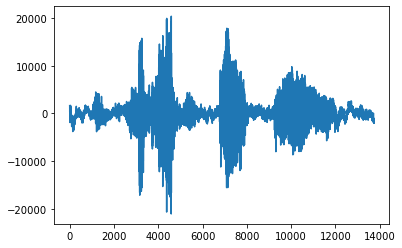

In [16]:
plt.plot(template)

In [17]:
print(motif_len_wav)

13749


In [18]:
mot_dict['start_ms']

array([  12830.14547884,   13350.1513751 ,   13872.15729403,
         14710.16679608,   15556.17638884,   16436.18636712,
       7315266.94656828, 7316338.95872365, 7317214.96865657,
       7318123.97896369])

In [19]:
mot_dict['start_t_ap_0']

array([  12.83021251,   13.35023873,   13.87217502,   14.71021434,
         15.55626437,   16.43627212, 7315.26699596, 7316.33899532,
       7317.21499361, 7318.12398729])

In [20]:
mot_dict['start_sample_ap_0']

array([   384907,    400508,    416166,    441307,    466689,    493089,
       219458073, 219490233, 219516513, 219543782])

In [21]:
mot_dict['start_t_0']

array([  12.83018548,   13.35019138,   13.87215729,   14.7102068 ,
         15.55621639,   16.43622637, 7315.26698657, 7316.33899872,
       7317.21500866, 7318.12401896])

1. 'nidq' imec file?
2. 'ap0' imec file? spiking data
3. 10 motifs?
4. end/length of motif? (same as template?) yes

# cluster_df

In [22]:
cluster_df = pickle.load(open(os.path.join(source_folder, cluster_meta_name), 'rb'))

In [23]:
cluster_df.tail()

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
808,808,mua,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[365, 358, 357, 362, 353, 364, 366, 368, 367, ...",365,"[353, 357, 358, 362, 364, 365, 366]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
813,813,mua,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[370, 373, 372, 344, 374, 362, 369, 371, 357, ...",370,"[344, 362, 369, 370, 372, 373, 374]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
814,814,mua,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[370, 363, 368, 356, 373, 361, 357, 369, 367, ...",370,"[356, 357, 361, 363, 368, 370, 373]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
807,807,mua,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[373, 365, 370, 358, 372, 349, 347, 363, 357, ...",373,"[347, 349, 358, 365, 370, 372, 373]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
815,815,mua,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[373, 355, 364, 372, 359, 352, 370, 369, 365, ...",373,"[352, 355, 359, 364, 370, 372, 373]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


In [24]:
cluster_df[cluster_df.cluster_id==143]

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
143,143,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[43, 40, 42, 45, 39, 44, 38, 41, 49, 46, 47, 3...",43,"[38, 39, 40, 42, 43, 44, 45]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


1. nucleus: only look for 'ra'? don't use nan
2. KSLabel: 'mua'? multi unit activity, 1) together 2) good 3) mua
3. channel: any use in this run? na

In [24]:
cluster_df.nucleus.value_counts()

ra     234
hvc     74
Name: nucleus, dtype: int64

In [25]:
cluster_df

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
0,0,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 1, 3, 4, 5, 23, 25, 21, 24, 18, 17, 10,...",0,"[0, 1, 2, 3, 4, 5, 23]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
1,1,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 3, 1, 6, 7, 5, 25, 8, 21, 10, 13, 23, 9...",0,"[0, 1, 2, 3, 5, 6, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
5,5,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 3, 5, 4, 6, 2, 7, 0, 8, 10, 9, 11, 22, 25,...",1,"[1, 2, 3, 4, 5, 6, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
7,7,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 5, 2, 12, 11, 28, 3, 29, 23, 10, 15, 26, 0...",1,"[1, 2, 3, 5, 11, 12, 28]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
14,14,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[4, 3, 2, 1, 0, 8, 6, 5, 10, 9, 11, 7, 12, 30,...",4,"[0, 1, 2, 3, 4, 6, 8]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
...,...,...,...,...,...,...,...,...
808,808,mua,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[365, 358, 357, 362, 353, 364, 366, 368, 367, ...",365,"[353, 357, 358, 362, 364, 365, 366]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
813,813,mua,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[370, 373, 372, 344, 374, 362, 369, 371, 357, ...",370,"[344, 362, 369, 370, 372, 373, 374]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
814,814,mua,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[370, 363, 368, 356, 373, 361, 357, 369, 367, ...",370,"[356, 357, 361, 363, 368, 370, 373]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
807,807,mua,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[373, 365, 370, 358, 372, 349, 347, 363, 357, ...",373,"[347, 349, 358, 365, 370, 372, 373]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


In [26]:
cluster_df.iloc[0].template.shape

(82, 375)

# spike_df

In [25]:
spike_df = pickle.load(open(os.path.join(source_folder, spike_data_name), 'rb'))

In [26]:
spike_df.head()

,times,clusters,nucelus,main_chan,kslabel
0,90,132,NaN,41,good
1,192,143,NaN,43,good
2,195,132,NaN,41,good
3,202,390,NaN,114,good
4,208,405,NaN,122,good


In [29]:
spike_df.nucelus.value_counts()

ra     21629954
hvc     2594579
Name: nucelus, dtype: int64

In [29]:
spike_df.times.values

array([       90,       192,       195, ..., 229265553, 229265553,
       229265558], dtype=uint64)

1. times in samples
2. clusters = cluster_id in cluster_df?
3. 

# visualize all motifs

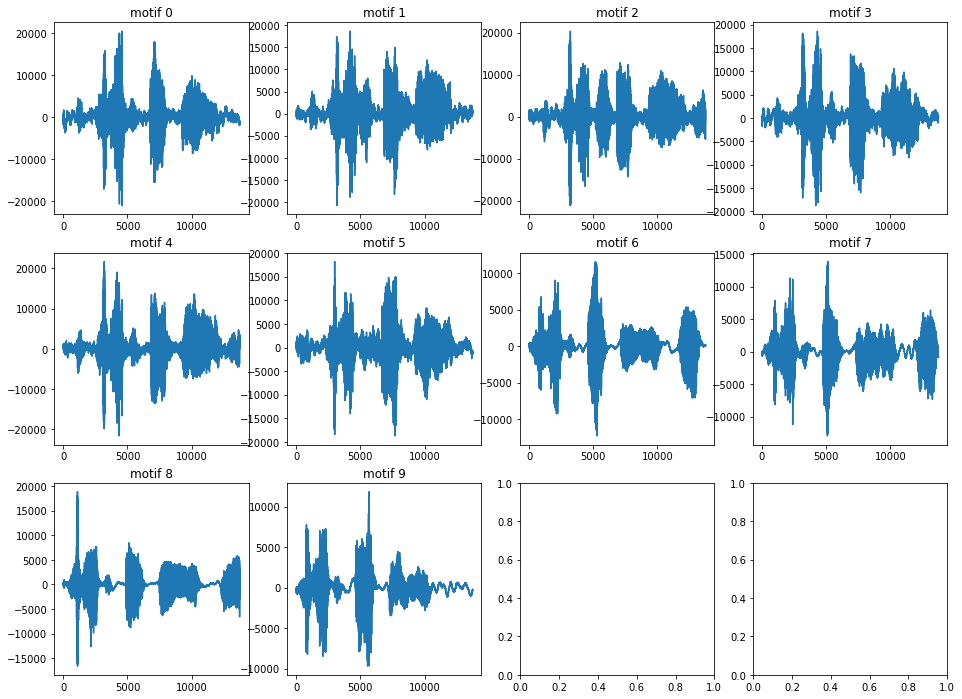

In [23]:
fig, ax = plt.subplots(3, 4, figsize=(16,12))
count = 0
for start in start_sample_wav:
    i = count//4
    j = count%4
    ax[i][j].plot(seq[start:start+motif_len])
    ax[i][j].set_title(f'motif {count}')
    count+=1

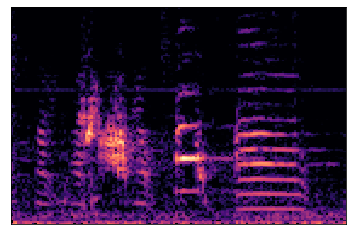

In [102]:
start = start_sample_wav[0]
this_motif = np.array(seq[start:start+motif_len_wav], dtype=float)
spec = np.abs(librosa.stft(this_motif, n_fft=256, hop_length=100, window='hann')) ** 2
# S_mel = librosa.feature.melspectrogram(this_motif, sr = wav_sr, n_mels=256, hop_length=256, n_fft=1024)
S_dB = librosa.power_to_db(spec, ref=np.max)
S_dB[S_dB<-50] = -50
S_norm = librosa.util.normalize(S_dB)
librosa.display.specshow(S_norm)

In [101]:
S_norm.shape

(129, 138)

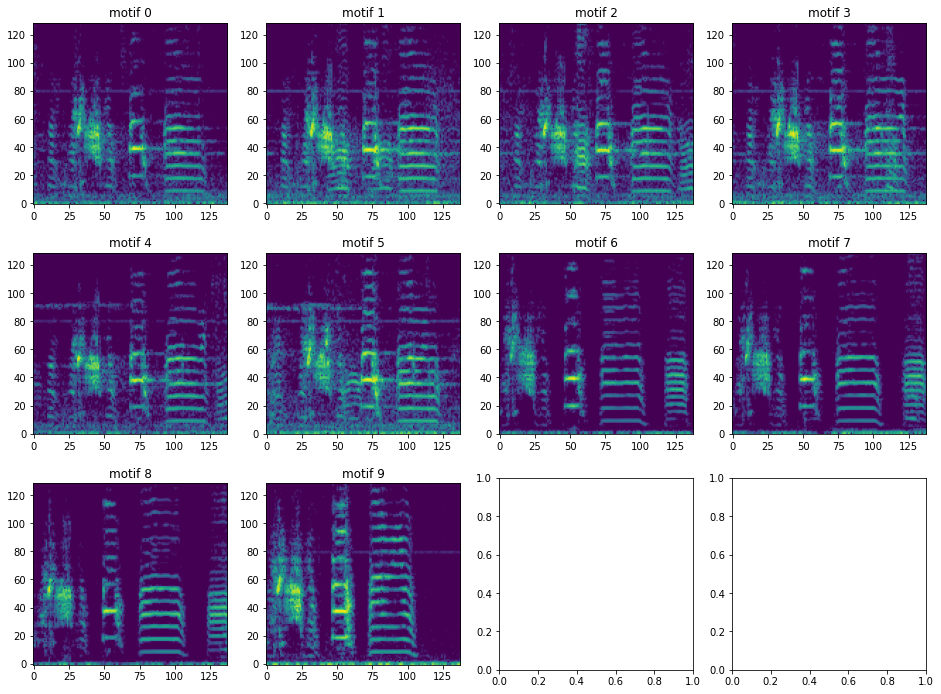

In [27]:
fig, ax = plt.subplots(3, 4, figsize=(16,12))
count = 0
spec_list = []
for start in start_sample_wav:
#     if count > 5:
#         start -= 2200
    i = count//4
    j = count%4
    this_motif = np.array(seq[start:start+motif_len_wav], dtype=float)
#     _, _, specgram = sg.spectrogram(this_motif, fs=wav_sr, 
#                                            nperseg=256,
#                                            noverlap=256-100,
#                                            nfft=None,
#                                            detrend='constant',
#                                            return_onesided=True,
#                                            scaling='density',
#                                            axis=-1,
#                                            mode='psd')
#     specgram /= specgram.max() # volume normalize to max 1
#     specgram = np.log10(specgram) # take log
#     specgram[specgram < -5] = -5 # set anything less than the threshold as the threshold
    spec = np.abs(librosa.stft(this_motif, n_fft=256, hop_length=100, win_length=256, window='hann')) ** 2
    S_dB = librosa.power_to_db(spec, ref=np.max)
    S_dB[S_dB<-50] = -50
    S_norm = librosa.util.normalize(S_dB)
    spec_list.append(S_norm.T[:, 1:])
    ax[i][j].imshow(S_norm, origin='lower')
    ax[i][j].set_title(f'motif {count}')
    count+=1
spec_list = np.array(spec_list)

In [35]:
specgram.shape

(129, 135)

In [114]:
np.array(spec_list).shape

(10, 138, 128)

# function to bin spikes

In [28]:
step_size_wav = 100
step_size_ap = int(step_size_wav/wav_sr*ap_sr)
print(step_size_ap)

120


In [29]:
fft_size = 256

In [30]:
def count_spikes(spike_df, start_sample_ap, step_size_ap, motif_len_ap, nucleus, n_lookbacks):
    nucleus_df = spike_df[spike_df.nucelus == nucleus].reset_index(drop=True) # spike_df has a typo column "nucelus"
    nucleus_clusters = list(nucleus_df.clusters.value_counts().keys()) # get all clusters within the nucleus
    num_clusters = len(nucleus_clusters) 
    cluster_index = {}  # create a dictionary of which row correspond to which cluster to avoid mismatch
    for i, cluster in enumerate(nucleus_clusters):
        cluster_index[str(cluster)] = i
        
    all_spike_counts = []
    motif_count = 0
    for start in start_sample_ap:
#         if motif_count>5:
#             start -= int(2200/wav_sr*ap_sr)
        start -= n_lookbacks*step_size_ap  # move backwards to adjust for lookback bins
        motif_spike_counts = []
        n_steps = motif_len_ap//step_size_ap+n_lookbacks
        for step in range(n_steps):
            start_sample = start + step*step_size_ap  # start and end of this bin/step in ap samples
            end_sample = start + (step+1)*step_size_ap
            step_spike_counts = [0]*num_clusters
            for cluster, counts in nucleus_df[(nucleus_df.times>start_sample) & 
                                              (nucleus_df.times<end_sample)].clusters.value_counts().items():
                step_spike_counts[cluster_index[str(cluster)]] = counts
            motif_spike_counts.append(step_spike_counts)
        all_spike_counts.append(motif_spike_counts)
        motif_count += 1
    return np.array(all_spike_counts)

In [31]:
n_lookbacks = 10

In [119]:
ra_counts = count_spikes(spike_df, start_sample_ap, step_size_ap, motif_len_ap, 'ra', n_lookbacks=n_lookbacks)

In [32]:
hvc_counts = count_spikes(spike_df, start_sample_ap, step_size_ap, motif_len_ap, 'hvc', n_lookbacks=n_lookbacks)

In [33]:
hvc_counts.shape

(10, 147, 73)

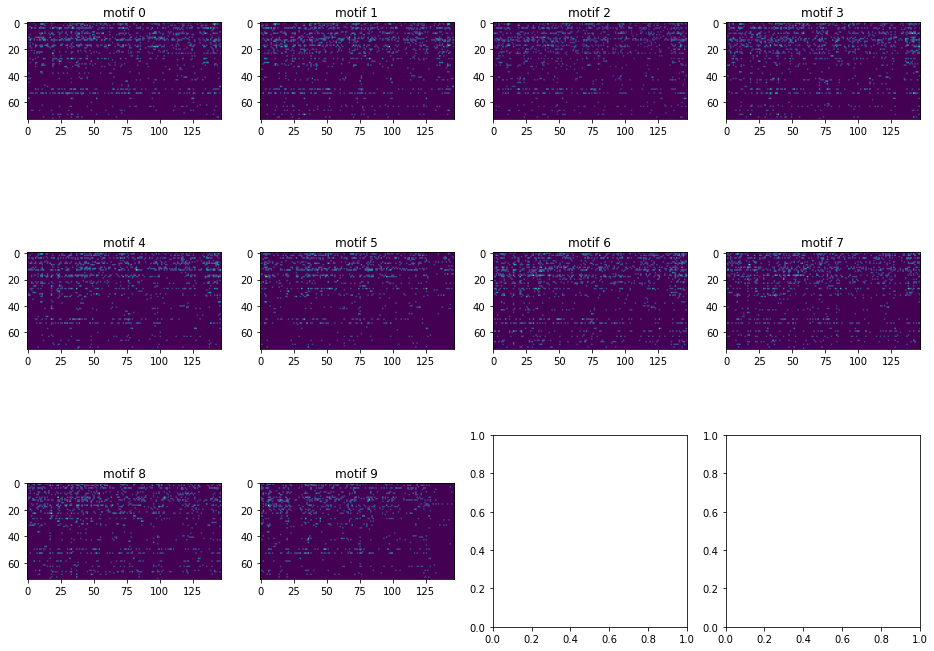

In [34]:
fig, ax = plt.subplots(3, 4, figsize=(16,12))
count = 0
for start in start_sample_wav:
    i = count//4
    j = count%4
    ax[i][j].imshow(np.array(hvc_counts[count]).T)
    ax[i][j].set_title(f'motif {count}')
    count+=1

In [65]:
np.sum(np.array(ra_counts), axis=(0, 1))

array([423, 560, 420, 290, 526, 382, 219, 340, 305, 435,  92, 164, 194,
       316, 417, 513,  92, 233, 211, 396, 357, 309, 221,  45, 271, 322,
       331, 309, 175, 361, 187, 322, 259, 351, 381, 320, 332, 119, 378,
       184,  18, 192, 238, 148, 150, 189, 192,   9, 268,  60, 258, 354,
       145, 222,  61, 166,  75,   0, 484,  97, 123, 135, 315, 126, 219,
       224, 140, 412,  26, 256, 131, 274,  89, 670, 124, 114,   0, 138,
        62,  99,  31,  88,  93,  24,   0,  24,  13, 144,   8,  37,  12,
        67,   2,  62,  33,  40,  14,   2,  40,   3,   5,  66,   8,  53,
       104, 155,   5,  19,  57, 647,   3,  25,   4,   7,  62,   6,  38,
        27,  21,   0,  25,  12,  28,  13,   1,  11,   6,  24,   4,   2,
        16,   6,   0,   2,   0,   6,   1,   7,   4,   2,   0,   4,  12,
        16,   2,   1,   0,   7,   0,   5,   1,   0,   6,   5,   1,  12,
         0,   5,   2,   2,   8,   1,   0,   0,   0,   2,   1,   3,   2,
         1,   1,   0,   1,   0,   0,   0,   0,   2,   0,   0,   

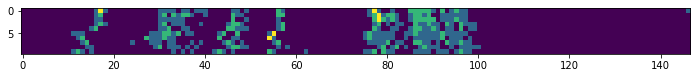

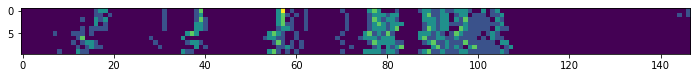

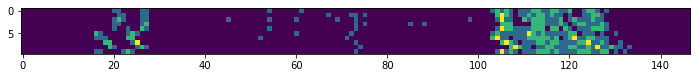

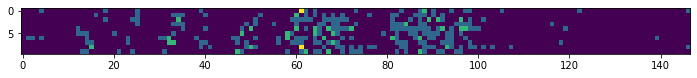

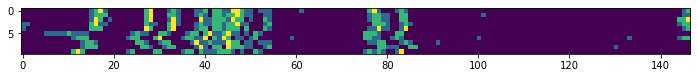

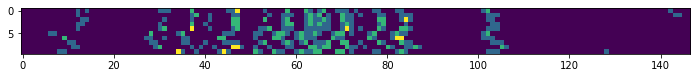

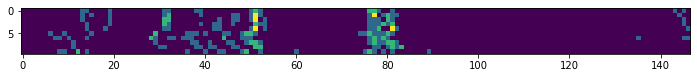

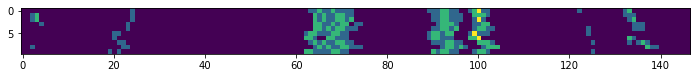

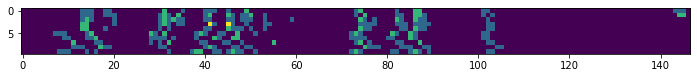

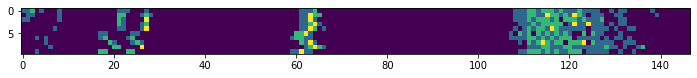

In [81]:
# before adjusting the last 4
for i in range(10):
    plt.figure(figsize=(12, 8))
    plt.imshow(np.array(ra_counts)[:, :, i])

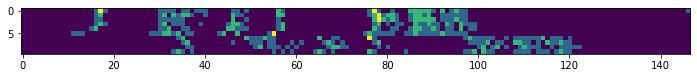

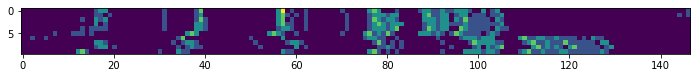

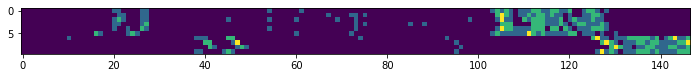

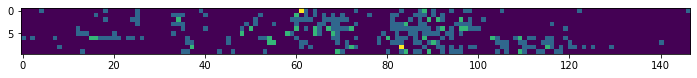

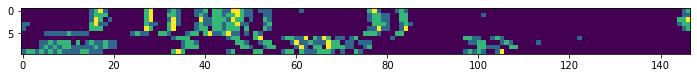

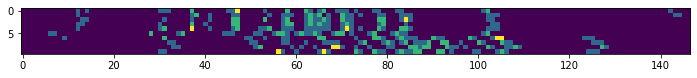

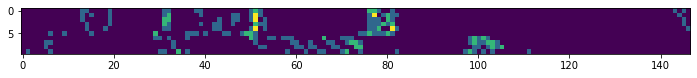

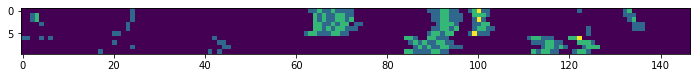

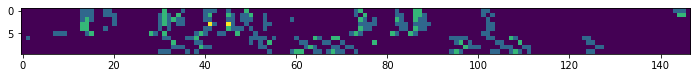

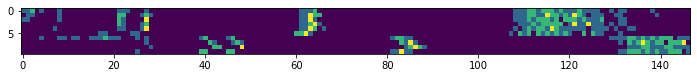

In [77]:
# after adjusting the last 4, we shouldn't adjust 
for i in range(10):
    plt.figure(figsize=(12, 8))
    plt.imshow(np.array(ra_counts)[:, :, i])

# compile everything into a single dataframe

spec_list has a shape of (n_motif, n_time, n_freq)

ra_counts has a shape of (n_motif, n_time, n_cluster), n_times include n_lookbacks at the beginning

In [35]:
input_list = []
output_list = []
motif_n_list = []
step_list = []
n_motifs = len(spec_list)
n_time = min(spec_list.shape[1], hvc_counts.shape[1]-n_lookbacks)
for i in range(n_motifs):
    spec = spec_list[i]
    spike = hvc_counts[i]
    for t in range(n_time):
        input_list.append(spike[t:t+n_lookbacks])
        output_list.append(spec[t])
        motif_n_list.append(i)
        step_list.append(t)

In [36]:
input_output_df = pd.DataFrame()
input_output_df['motif'] = motif_n_list
input_output_df['step'] = step_list
input_output_df['input'] = input_list
input_output_df['output'] = output_list

In [37]:
input_output_df.tail()

,motif,step,input,output
1365,9,132,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[-0.34626780131000034, -0.6976743063570495, -0..."
1366,9,133,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.4414303893804583, -0.6573171533142144, -1...."
1367,9,134,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.45199486637298775, -0.6906773651003755, -0..."
1368,9,135,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.28211163644209253, -0.6644469578173456, -0..."
1369,9,136,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.2459257798562328, -0.7444524827126306, -0...."


In [38]:
save_name = f'input_output_{datetime.datetime.now():%Y_%m_%d_%H_%M}'
input_output_df.to_pickle(os.path.join('/mnt/cube/kai/data_processed/bci/prelim_10_motif/', save_name+'.p'))

In [39]:
with open(os.path.join('/mnt/cube/kai/data_processed/bci/prelim_10_motif/', save_name+'.txt'), 'w+') as file:
    file.write(f'fft_size: {fft_size}\n')
    file.write(f'step_size_wav: {step_size_wav}\n')
    file.write(f'n_lookbacks: {n_lookbacks}\n')
    file.write(f'nucleus: hvc\n')
    file.write(f'kslabel: all\n')